# Entraînement du Modèle avec Transfer Learning (MobileNetV2)

Ce notebook entraîne un CNN pour classifier les maladies des plantes.

In [3]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Définir le style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print(f"Version TensorFlow : {tf.__version__}")

Version TensorFlow : 2.19.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploration et Prétraitement des Données

Ce notebook explore le jeu de données Plant Disease, visualise les classes et met en place l'augmentation des données.

## Structure du Dataset et Distribution des Classes

Total classes Entraînement : 10
Total classes Validation : 10


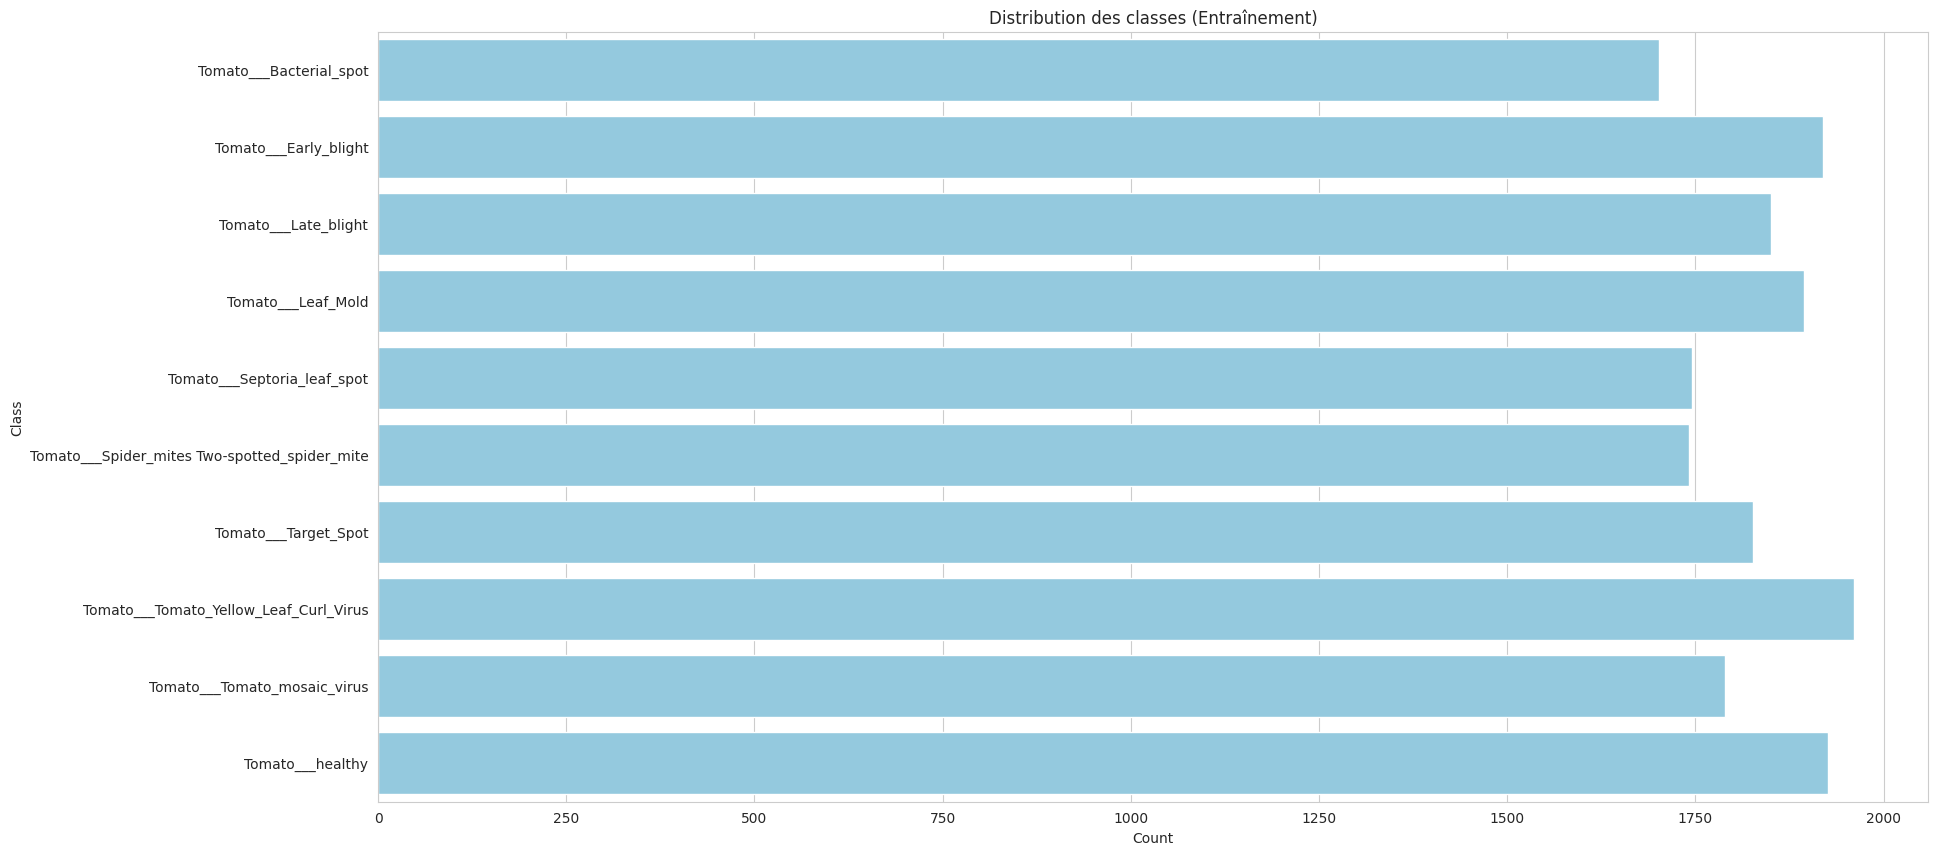

In [4]:
TRAIN_DIR = '/content/drive/MyDrive/Colab Notebooks/DataHubProject/Dataset/train'
VALID_DIR = '/content/drive/MyDrive/Colab Notebooks/DataHubProject/Dataset/valid'

def get_class_distribution(dir_path):
    classes = sorted(os.listdir(dir_path))
    # Filtrer les fichiers cachés comme .DS_Store
    classes = [c for c in classes if not c.startswith('.')]
    count = []
    for c in classes:
        count.append(len(os.listdir(os.path.join(dir_path, c))))
    return pd.DataFrame({'Class': classes, 'Count': count})

train_dist = get_class_distribution(TRAIN_DIR)
valid_dist = get_class_distribution(VALID_DIR)

print(f"Total classes Entraînement : {len(train_dist)}")
print(f"Total classes Validation : {len(valid_dist)}")

# Affichage graphique
plt.figure(figsize=(20, 10))
sns.barplot(data=train_dist, x='Count', y='Class', color='skyblue')
plt.title('Distribution des classes (Entraînement)')
plt.show()

## Visualiser des Images Exemples

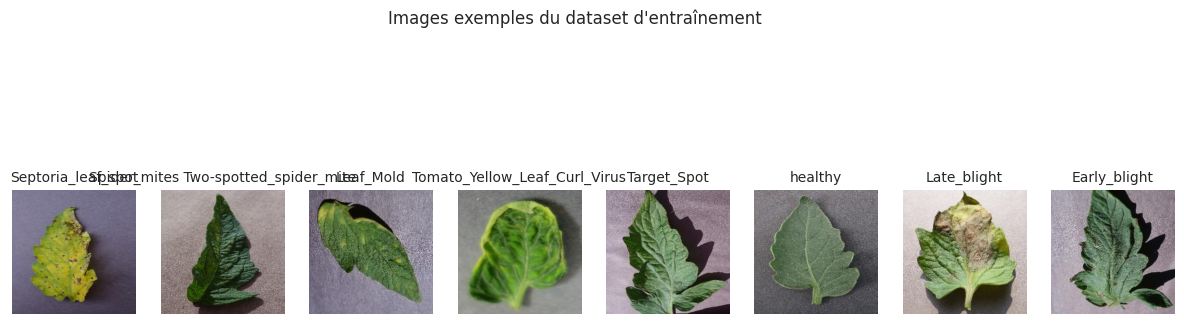

In [13]:
def visualize_samples(dir_path, num_samples=5):
    classes = [c for c in os.listdir(dir_path) if not c.startswith('.')]
    random_classes = np.random.choice(classes, num_samples, replace=False)

    plt.figure(figsize=(15, 5))
    for i, c in enumerate(random_classes):
        class_dir = os.path.join(dir_path, c)
        images = os.listdir(class_dir)
        img_name = np.random.choice(images)
        img_path = os.path.join(class_dir, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(c.split('___')[-1], fontsize=10)
        plt.axis('off')
    plt.suptitle("Images exemples du dataset d'entraînement")
    plt.show()

visualize_samples(TRAIN_DIR, num_samples=8)

## Configuration de l'Augmentation des Données
Nous utiliserons ImageDataGenerator pour augmenter les images à la volée.

Images Augmentées :


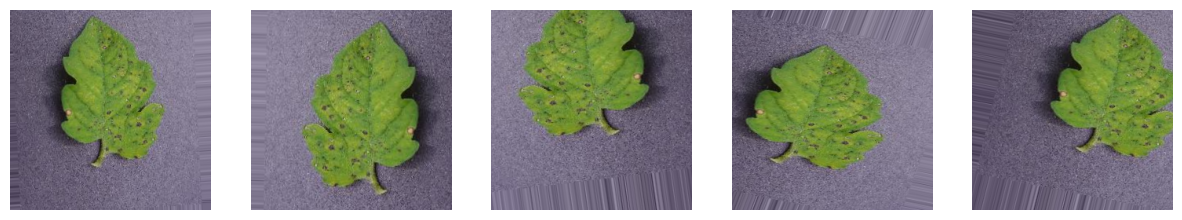

In [14]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Choisir une image pour démontrer l'augmentation
classes = [c for c in os.listdir(TRAIN_DIR) if not c.startswith('.')]
sample_class = classes[0]
sample_img_name = os.listdir(os.path.join(TRAIN_DIR, sample_class))[0]
sample_img_path = os.path.join(TRAIN_DIR, sample_class, sample_img_name)

img = cv2.imread(sample_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, 0) # Ajouter dimension batch

plt.figure(figsize=(15, 5))
i = 0
print("Images Augmentées :")
for batch in datagen.flow(img, batch_size=1):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0])
    plt.axis('off')
    i += 1
    if i >= 5:
        break
plt.show()

## Générateurs de Données

In [15]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
print(f"Nombre de classes : {num_classes}")

# SAUVEGARDER LES INDICES DE CLASSE
class_indices = train_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()} # Inverser pour obtenir index -> classe
with open('/content/drive/MyDrive/Colab Notebooks/DataHubProject/models/class_indices.json', 'w') as f:
    json.dump(class_indices, f)
print("Indices de classe sauvegardés dans class_indices.json")

Found 18357 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.
Nombre de classes : 10
Indices de classe sauvegardés dans class_indices.json


## Architecture du Modèle (Transfer Learning)

In [16]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler le modèle de base
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Entraînement

In [17]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True)
]

EPOCHS = 10

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6246 - loss: 1.1061 

574/574 ━━━━━━━━━━━━━━━━━━━━ 14698s 26s/step - accuracy: 0.6247 - loss: 1.1055 - val_accuracy: 0.8251 - val_loss: 0.5126
Epoch 2/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8133 - loss: 0.5400

574/574 ━━━━━━━━━━━━━━━━━━━━ 243s 423ms/step - accuracy: 0.8134 - loss: 0.5399 - val_accuracy: 0.8589 - val_loss: 0.4138
Epoch 3/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 237s 413ms/step - accuracy: 0.8376 - loss: 0.4626 - val_accuracy: 0.8534 - val_loss: 0.4109
Epoch 4/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8614 - loss: 0.3989

574/574 ━━━━━━━━━━━━━━━━━━━━ 239s 416ms/step - accuracy: 0.8614 - loss: 0.3989 - val_accuracy: 0.8739 - val_loss: 0.3716
Epoch 5/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 236s 411ms/step - accuracy: 0.8697 - loss: 0.3740 - val_accuracy: 0.8578 - val_loss: 0.3964
Epoch 6/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 236s 412ms/step - accuracy: 0.8717 - loss: 0.3669 - val_accuracy: 0.8595 - val_loss: 0.4051
Epoch 7/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8791 - loss: 0.3569

574/574 ━━━━━━━━━━━━━━━━━━━━ 238s 414ms/step - accuracy: 0.8791 - loss: 0.3569 - val_accuracy: 0.8814 - val_loss: 0.3451
Epoch 8/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 242s 421ms/step - accuracy: 0.8845 - loss: 0.3329 - val_accuracy: 0.8700 - val_loss: 0.3880
Epoch 9/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8871 - loss: 0.3284

574/574 ━━━━━━━━━━━━━━━━━━━━ 239s 416ms/step - accuracy: 0.8871 - loss: 0.3283 - val_accuracy: 0.8957 - val_loss: 0.3222
Epoch 10/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 234s 408ms/step - accuracy: 0.8840 - loss: 0.3231 - val_accuracy: 0.8807 - val_loss: 0.3314


## Évaluation et Sauvegarde

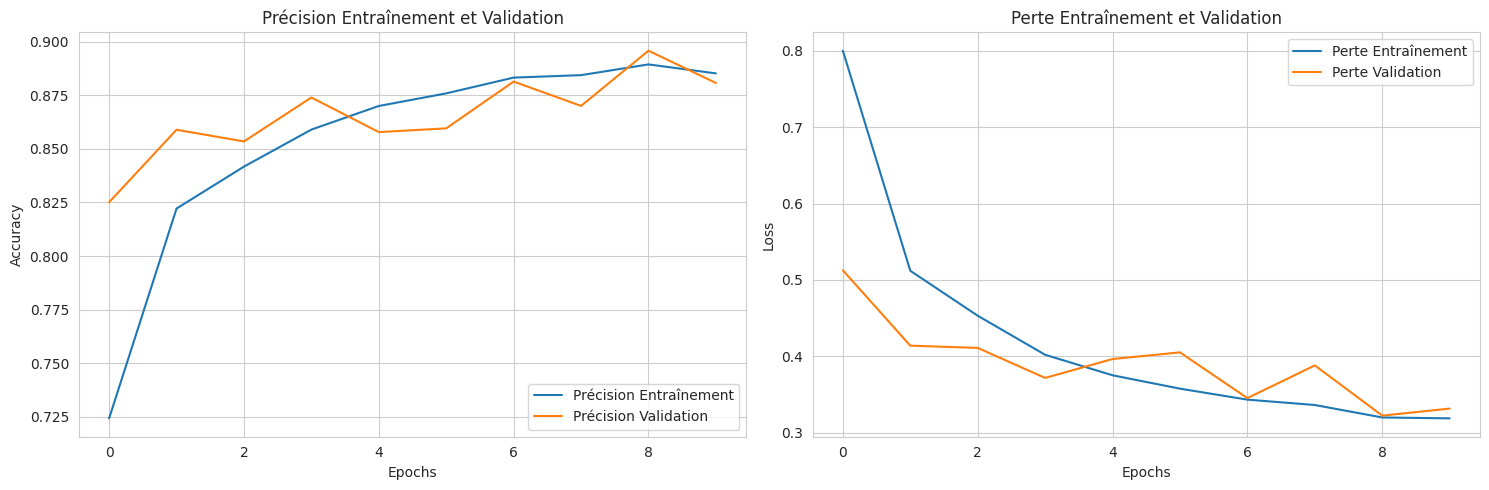

Génération des prédictions...
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step


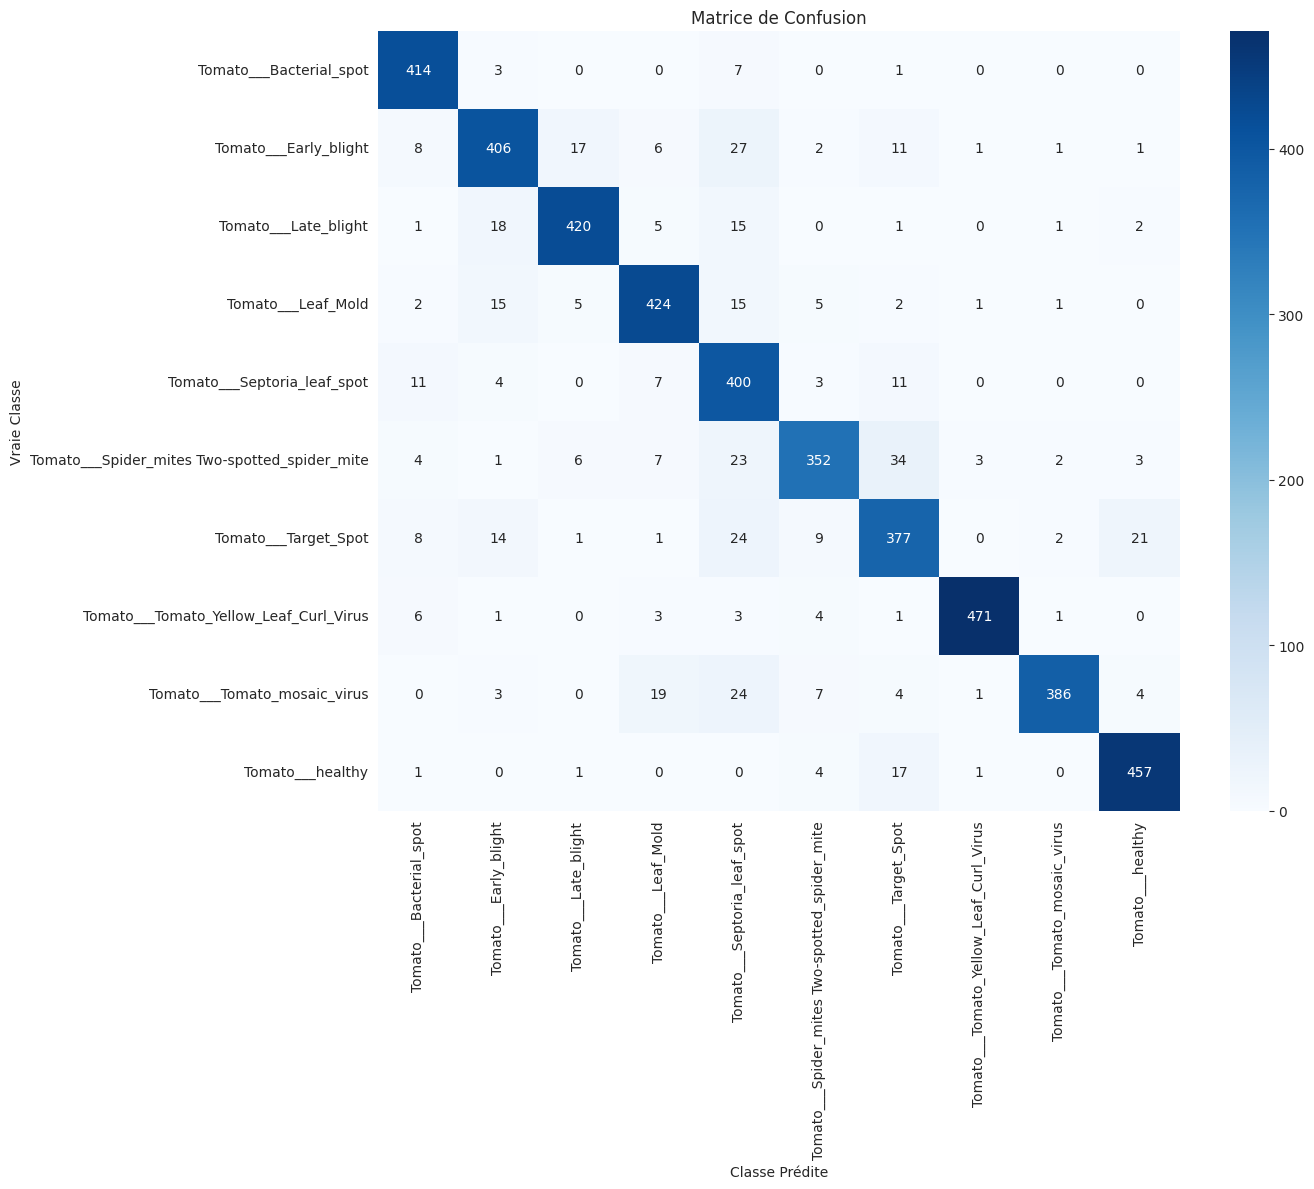


--- Scores Globaux ---
Accuracy (Précision Globale) : 0.8957
Macro F1-Score              : 0.8956
Weighted F1-Score           : 0.8964
Perte Globale               : 0.3222

✅ Figures et modèle sauvegardés avec succès.


In [20]:
# ===============================
# IMPORTS
# ===============================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score
)

# ===============================
# DOSSIER DE SAUVEGARDE
# ===============================
FIGURES_DIR = "/content/drive/MyDrive/Colab Notebooks/DataHubProject/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

# ===============================
# COURBES D'APPRENTISSAGE
# ===============================
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))

# --- Précision ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Précision Entraînement')
plt.plot(epochs_range, val_acc, label='Précision Validation')
plt.legend(loc='lower right')
plt.title('Précision Entraînement et Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# --- Perte ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perte Entraînement')
plt.plot(epochs_range, val_loss, label='Perte Validation')
plt.legend(loc='upper right')
plt.title('Perte Entraînement et Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Sauvegarde
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES_DIR, "courbes_precision_perte.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

# ===============================
# ÉVALUATION DÉTAILLÉE
# ===============================
valid_generator.reset()

print("Génération des prédictions...")
predictions = model.predict(valid_generator)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = valid_generator.classes
class_labels = list(valid_generator.class_indices.keys())

# ===============================
# MATRICE DE CONFUSION
# ===============================
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)

plt.title('Matrice de Confusion')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Sauvegarde
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES_DIR, "matrice_confusion.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

# ===============================
# SCORES GLOBAUX
# ===============================
loss, accuracy = model.evaluate(valid_generator, verbose=0)

macro_f1 = f1_score(true_classes, predicted_classes, average='macro')
weighted_f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("\n--- Scores Globaux ---")
print(f"Accuracy (Précision Globale) : {accuracy:.4f}")
print(f"Macro F1-Score              : {macro_f1:.4f}")
print(f"Weighted F1-Score           : {weighted_f1:.4f}")
print(f"Perte Globale               : {loss:.4f}")

# ===============================
# SAUVEGARDE DU MODÈLE
# ===============================
model.save(
    "/content/drive/MyDrive/Colab Notebooks/DataHubProject/models/plant_disease_model.keras"
)

print("\n✅ Figures et modèle sauvegardés avec succès.")
